# Linear least squares fit

## Tasks

Perform a least squares fit of a parabola

$$ y(x) = \theta_0 + \theta_1 x + \theta_2 x^2$$

for the seven independent measurments $(x_i, y_i)$ given by $(-0.75, 1.0 \pm 1.0)$, $(-0.5, 4.0 \pm 1.0)$, $(-0.25, 4.0 \pm 0.5)$, $(0.0, 5.5 \pm 0.5)$, $(0.25, 4.5 \pm 0.5)$, $(0.5, 5.5 \pm 1.0)$, $(0.75, 3.0 \pm 1.0)$. 

a) Determine the best fit parameters $\hat \theta_i$ and their covariances using the formula for linear least squares fits.

b) Determine the $\chi_\mathrm{obs}^2$ for the best fit parameter. What is the number of degrees of freedom? Plot the $\chi^2$ distribution and indicate $\chi_\mathrm{obs}^2$ in this plot (e.g. by drawing a line at this value).
What is the $p$-value for this fit?

c) Plot the fitted parabola and the $1\sigma$ error band around it as obtaind from the error propagation formula $\sigma_y^2 = A^\mathrm{T} U A$. What is the predicted value $y$ at $x=1$ and its uncertainty?

d) Compare the fit result and the covariance matrix with the results obtained with iminuit. Do the results agree?

e) Determine the $p$-value for a straight-line fit. Is thhis an acceptable description of the data?


### Hints

1) The following numpy functions might come in very handy
* diagonal matrix from vector v in numpy: *A = np.diagflat(v)*
* matrix from column vectors v0, v1, v2: *A = np.column_stack((v0, v1, v2))*
* multiplication of matrices A and B in numpy: *C = A.dot(B)*
* transposed matrix: *A_T = np.transpose(A)*
* inverse matrix: *A_inv = inv(A)*, this requires *from numpy.linalg import inv*

2) It might be useful to write a function which returns the uncertainty $\sigma_y$ for a numpy array of $x$ values. A function $f$ that only works for a scalar value $x$ can be vectorized (i.e., it works also for numpy arrays) with *numpy.vectorize*.

3) Data points with error bars can be drawn with *plt.errorbar(x, y, yerr=sigma_y)*

4) A band between $y$ values can be drawn with the aid of *matplotlib.pyplot.fill_between*

## Comments on Python's `iminuit`

The KIP service has iminuit version 1.3.8. Please note that the most recent version is $\geq2.0.0$ and that the [documentation](https://iminuit.readthedocs.io/en/stable/) applies to *that* version. Some backward-incompatible changes have been introduced, some of which changed some interfaces. For your tasks that mainly affects the `minuit.Minuit` constructor. The following shows the construction of a `Minuit` object for version 1.3.8 (in case you use the KIP service or a version $<2.0.0$) and $\geq2.0.0$ (in case you use another service implementing a higher version), respectively.
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=1
# likelihood method: errordef=0.5
m = Minuit(func, par1=0.1, par2=0.1, ..., parN=0.1, errordef=1)
```

And this would be the equivalent workflow for versions >2.0.0
```python
from iminuit import Minuit

def func(par1, par2, ..., parN):
    return minimise_something(par1, par2, ..., parN)

# least squares method: errordef=Minuit.LEAST_SQUARES
# likelihood method: errordef=Minuit.LIKELIHOOD

# add errordef as an attribute of your defined minimisation function which will be checked for when optimised
func.errordef = Minuit.LEAST_SQUARES
m = Minuit(func, par1=0.1 par2=0.1, ..., parN=0.1)
```

Another (potenitally) Jupiter related *feature* is the fact that `m.migrad()`, `m.matrix()`, `m.minos()` etc. can yield a nice summary of the respective procedure. However, in order to show it, either of these methods (and potentially others in case you use them) have to be *the last line of a code cell*. If there is *anything* coming afterwards, the output will not be printed, hence, for anything that follows, it is recommended to start a new code cell.


## Solution

In [2]:
import numpy as np                     #Math
import matplotlib.pyplot as plt        #Plot
from numpy.linalg import inv           #Inverse
import numpy.matlib                    #
import scipy.stats as stats            #Chi squared
from sympy import *                    #error propagation
from IPython.display import display, Latex #Latex display
from iminuit import Minuit

ModuleNotFoundError: No module named 'iminuit'

In [3]:
# data
x = np.array([-0.75, -0.5, -0.25, 0., 0.25, 0.5, 0.75])
y = np.array([1., 4.0, 4., 5.5, 4.5, 5.5, 3])
sigma_y = np.array([1, 1, 0.5, 0.5, 0.5, 1, 1])

In [5]:
#a) Determine optimal parameters and respective covariances
A = np.matlib.empty((len(x),3))
for i in range(len(x)):
    for j in range(3):
        A[i,j] = x[i]**j
print(A)
C = np.diag(sigma_y**2) #'independend measurements'
G = inv(np.transpose(A).dot(inv(C).dot(A))).dot(np.transpose(A).dot(inv(C)))
lam_opt = G.dot(y)
print(lam_opt)
C_lam  = inv(np.transpose(A).dot(inv(C).dot(A)))
print(C_lam)

[[ 1.     -0.75    0.5625]
 [ 1.     -0.5     0.25  ]
 [ 1.     -0.25    0.0625]
 [ 1.      0.      0.    ]
 [ 1.      0.25    0.0625]
 [ 1.      0.5     0.25  ]
 [ 1.      0.75    0.5625]]
[[ 4.99373796  1.29411765 -4.89402697]]
[[ 0.0973025   0.         -0.26204239]
 [ 0.          0.47058824  0.        ]
 [-0.26204239  0.          1.97302505]]


fit-prob = 32.39%
n.d.f = 4
chi = 4.661070497563187


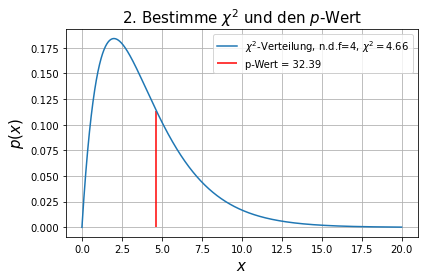

In [24]:
#b)chi, n.d.f, plot, p-Value
def chisquareValue(xvalue, yvalues, sigma_y, fit_parameter, function):
    chi2=0
    for i in range(len(xvalue)):
        expected = function(xvalue[i], *fit_parameter)
        chi2+=((expected-yvalues[i])/sigma_y[i])**2
    prob = round(1 - stats.chi2.cdf(chi2, len(xvalue) - len(fit_parameter)), 4) * 100
    return chi2/(len(xvalue)-len(fit_parameter)), prob #chis2 per degree of freedom and probability
def Quadratic(x, C1, C2, C3):
    return C1+C2*x+C3*x**2
fit_parameter = np.array([lam_opt[0,0], lam_opt[0,1], lam_opt[0,2]])
chi_ndf, prob = chisquareValue(x,y,sigma_y, fit_parameter, Quadratic)
print("fit-prob = {}%".format(prob))
print("n.d.f = {}".format(len(x)-len(fit_parameter)))
print("chi = {}".format(chi_ndf * (len(x)-len(fit_parameter))))
#finally plot chi-square function and indicate chi value
interval = np.arange(0, 20, 0.01)
plt.title(r'2. Bestimme $\chi^2$ und den $p$-Wert', size=15)
plt.ylabel(r'$p(x)$',size=15)
plt.xlabel(r'$x$', size=15)
plt.vlines(chi_ndf * (len(x)-len(fit_parameter)), 0, stats.chi2.pdf(chi_ndf * (len(x)-len(fit_parameter)), df=4), color='r',label='p-Wert = {0}'.format(round(prob,2)))
plt.plot(interval, stats.chi2.pdf(interval, df=len(x)-len(fit_parameter)), label=r'$\chi^2$-Verteilung, n.d.f=4, $\chi^2=${0}'.format(round(chi_ndf * (len(x)-len(fit_parameter)),2)))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('..\präsentation\svg\chi.pdf',format='pdf')
####################################################
#it should be 32.39%, although the plot tells other#
####################################################

<IPython.core.display.Latex object>

f(1) = 1.3938286297177838 +/- 1.42015175592631


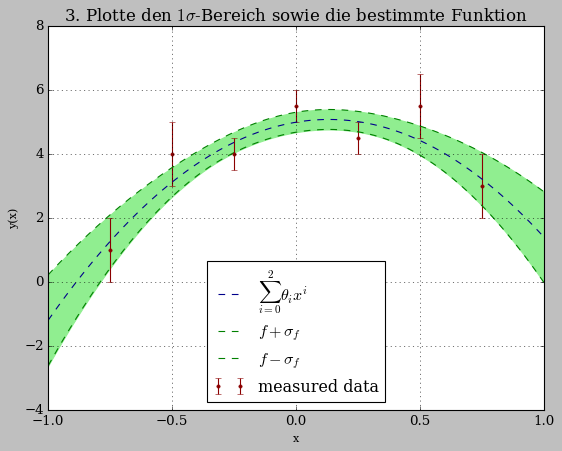

In [26]:
#c) plot, 1sigma error bar, x=1 value
############
#groundwork#
############
def error_prop_corr(f, x, V, divide=False):
    """
    f: function f = f(x[0], x[1], ...)
    x: list of variables
    V: covariance matrix (python 2d list)
    divide: set true for relative uncertainty
    """
    sum = S(0) # empty sympy expression
    for i in range(len(x)):
        for j in range(len(x)):
            sum += diff(f, x[i]) * diff(f, x[j]) * V[i,j] 
    if divide:
        sum = sum / f**2
    return sqrt(simplify(sum))
a,b,c,d = symbols('\theta_0,\theta_1,\theta_2, x', real=True)
f = a+b*d+c*d**2 #a+bx+cx**2 with x=d
sigma_f = error_prop_corr(f, [a,b,c], C_lam)
result_f = "$${} = {}$$".format("\sigma (f(\lambda_i;x))", latex(sigma_f))
display(Latex(result_f))

nx = np.linspace(-1, 1, 100)
df = np.zeros(len(nx))
for i in range(len(df)):
    df[i] = sigma_f.subs([(d, nx[i])]).evalf()

####################
#plot related stuff#
####################
plt.style.use('classic')
plt.rcParams["font.family"]='serif'
plt.clf()
plt.title(r'3. Plotte den $1\sigma$-Bereich sowie die bestimmte Funktion', size=15)
plt.errorbar(x, y, xerr=None, yerr=sigma_y, color='darkred', ls='', fmt='.', label='measured data')
plt.plot(nx, Quadratic(nx,*fit_parameter), color='darkblue', ls='--', label=r'$\sum_{i=0}^2\theta_ix^i$')
plt.plot(nx, Quadratic(nx,*fit_parameter)+df, color='g', ls='--', label=r'$f+\sigma_f$')
plt.plot(nx, Quadratic(nx,*fit_parameter)-df, color='g', ls='--', label=r'$f-\sigma_f$')

plt.fill_between(nx, Quadratic(nx, *fit_parameter)-df, Quadratic(nx, *fit_parameter)+df, color='lightgreen')

plt.ylabel('y(x)', size=10)
plt.xlabel('x', size=10)
plt.grid(True)
plt.legend(frameon=True, loc='best')
plt.savefig('..\präsentation/svg/fit.pdf',format='pdf')
######
#f(1)#
######
f_1 = Quadratic(1, *fit_parameter)
df_1 = sigma_f.subs([(d,1)]).evalf()
print("f(1) = {0} +/- {1}".format(f_1, df_1))

In [6]:
#d) Compare with iminuit
def chi2(C1,C2,C3):
    fy = Quadratic(x, C1,C2,C3)
    diffs = (y-fy)/sigma_y
    return np.sum(diffs**2)
Quadratic.errordef = Minuit.LEAST_SQUARES
m = Minuit(chi2, C1=5, C2=1.3, C3=-5)

In [7]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.661                      │              Nfcn = 45               │
│ EDM = 2.19e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ C1   │   4.99    │   0.31    │            │            │         │         │       │
│ 1 │ C2   │    1.3    │    0.7    │            │            │         │         │       │
│ 2 │ C3   │   -4.9    │    1.4    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────────────┐
│    │        C1        C2        C3 │
├────┼───────────────────────────────┤
│ C1 │    0.0973 -5.25e-11    -0.262 │
│ C2 │ -5.25e-11     0.471  3.96e-10 │
│ C3 │    -0.262  3.96e-10      1.97 │
└────┴───────────────────────────────┘

In [8]:
m.fval

4.661092383273487

The results are exactly the same

In [14]:
#e) Straight line p-value
def func(x,a, b):
    return a*x+b
def chi2_new(a,b):
    fy = func(x, a,b)
    diffs = (y-fy)/sigma_y
    return np.sum(diffs**2)
func.errordef = Minuit.LEAST_SQUARES
m = Minuit(chi2_new, a=0, b=2)
m.migrad()
chi2_new = m.fval
pvalue = 1 - stats.chi2.cdf(chi2_new, len(x)-2)
print(pvalue)

0.004894009158931678


p-value should ideally be 0.5 which is equvialent to chi_n.d.f = 1.
However, this isn't the case. This model doesn't describe the physics.